In [1]:
# Google Colabで、Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

#/root/.kaggleを作成して、apiを使えるようにする。
!sudo mkdir /root/.kaggle
!cp /content/drive/MyDrive/.kaggle/kaggle.json /root/.kaggle/kaggle.json

# cdは!が使えない。マジックコマンド%で移動
import os
os.makedirs('/content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction/EDA', exist_ok=True)
%cd /content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction/
%ls -a

Mounted at /content/drive
/content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction
checkpoint                               protos/
EDA/                                     QuantileScaler.pkl
example_sample_submission.parquet        QuantileTransformer.pkl
example_test.parquet                     res/
.git/                                    RobustScaler.pkl
holidays_of_china_from_2014_to_2030.csv  solutions.txt
ideas.txt                                StandardScaler.pkl
investment_ids/                          tf_datas/
investment_ids.csv                       tf_models/
MinMaxScaler.pkl                         train_low_mem.parquet
model.png                                train.parquet


In [2]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, GroupKFold, train_test_split, KFold
from sklearn.metrics import mean_squared_error

import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

from scipy import stats
from scipy.stats import pearsonr
import lightgbm as lgb
import lightgbm


import time
import random
from tqdm.autonotebook import tqdm
from pprint import pprint
import copy
import pickle
from pathlib import Path
from joblib import Parallel, delayed
import joblib

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# !pip install umap-learn hdbscan
import gc, random
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import umap, hdbscan
import missingno as msno

# from kuma_utils.preprocessing.imputer import LGBMImputer
# from ppca import PPCA

from sklearn.covariance import LedoitWolf
from sklearn.preprocessing import StandardScaler

from scipy.stats import zscore
from scipy.spatial import distance
from scipy.cluster import hierarchy

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (16, 5)

In [4]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [ ]:
%%time
# train = pd.read_parquet('train.parquet')
train = pd.read_parquet('train_low_mem.parquet')

print(train.info())
train.head(3)

%cd /content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction/EDA

<Figure size 1152x360 with 0 Axes>

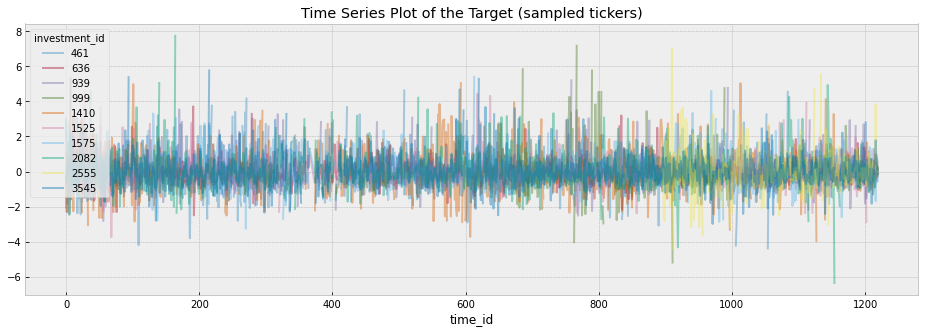

In [ ]:
sample_tickers = random.sample(list(train.investment_id.unique()), 10)
plt.figure()
train.query('investment_id in @sample_tickers').set_index(['time_id', 'investment_id'])['target'].unstack()\
     .plot(alpha=0.4, title='Time Series Plot of the Target (sampled tickers)')
plt.savefig('TimeSeriesPlot_of_the_Target.jpg')

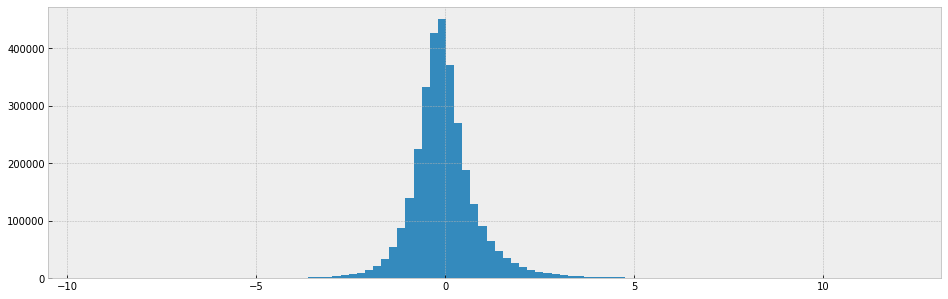

In [ ]:
plt.figure()
train.target.hist(bins=100)
plt.savefig('target_histgram.jpg')

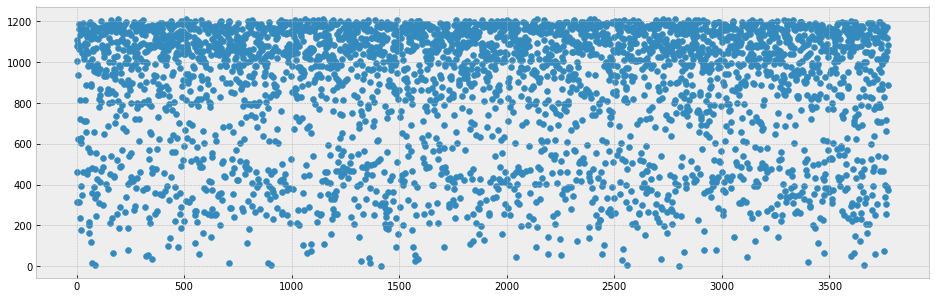

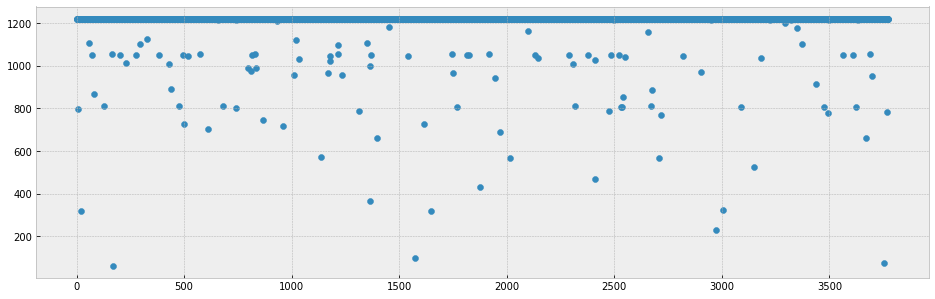

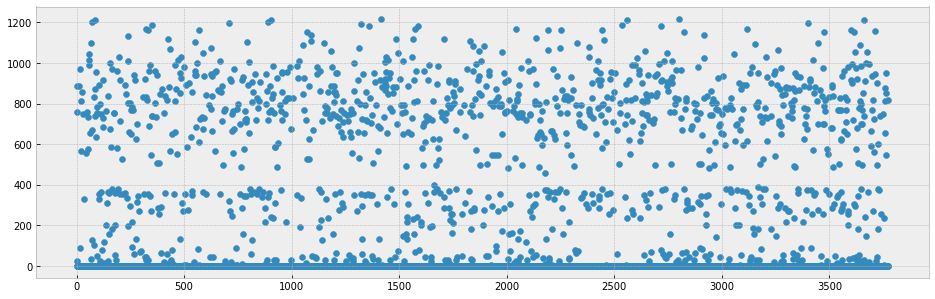

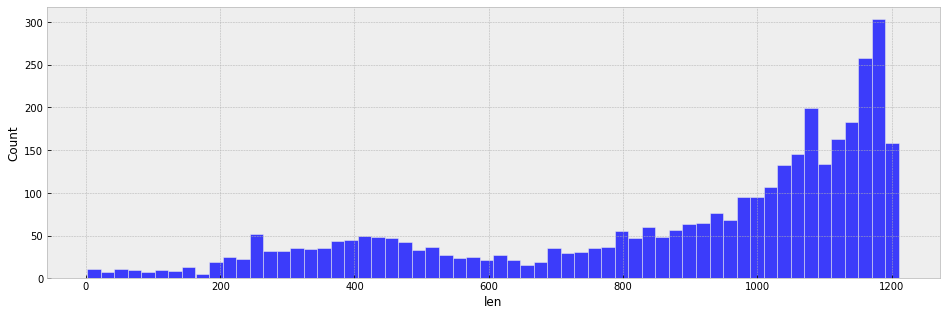

In [ ]:
def plot_max_time_id(df, x='investment_id', y='time_id', title='len'):
    gdf = df.groupby(x, as_index=False)[y].agg([len, max, min]).reset_index()
    plt.figure()
    plt.scatter(gdf[x], gdf[title])
    plt.figure()
    plt.scatter(gdf[x], gdf['max'])
    plt.figure()
    plt.scatter(gdf[x], gdf['min'])
    plt.figure()
    sns.histplot(gdf[title], bins=60)
    plt.savefig("target_frequency_by_asset.jpg")
    return gdf.reset_index()
gdf = plot_max_time_id(train)
# plot_max_time_id(tra)
# plot_max_time_id(val)

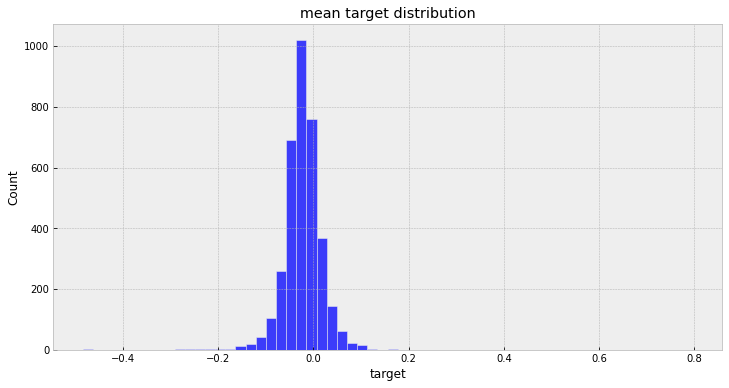

Mean of mean target: -0.02310


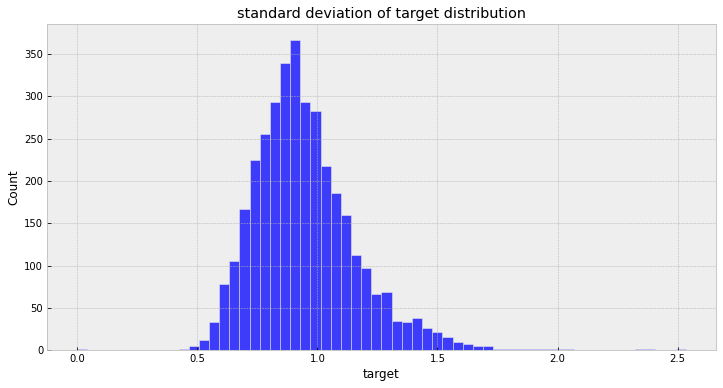

Mean of std target:  0.94790


In [ ]:
mean_target = train.groupby(['investment_id'])['target'].mean()
mean_mean_target = np.mean(mean_target)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(mean_target, bins=60)
# mean_target.plot.hist(bins=60)
plt.title("mean target distribution")
plt.show()

print(f"Mean of mean target: {mean_mean_target: 0.5f}")

sts_target = train.groupby(['investment_id'])['target'].std()
mean_std_target = np.mean(sts_target)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# sts_target.plot.hist(bins=60)
sns.histplot(sts_target, bins=60)
plt.title("standard deviation of target distribution")
plt.show()

print(f"Mean of std target: {mean_std_target: 0.5f}")

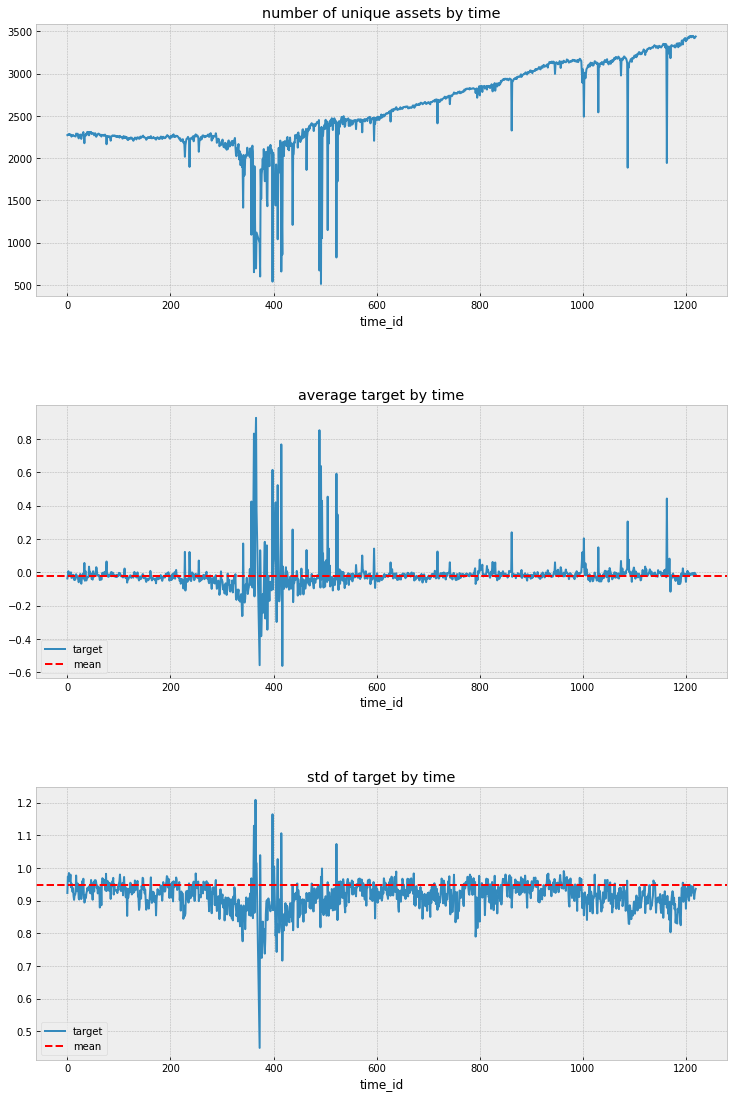

In [ ]:
mean_target = train.groupby(['investment_id'])['target'].mean()
mean_mean_target = np.mean(mean_target)
sts_target = train.groupby(['investment_id'])['target'].std()
mean_std_target = np.mean(sts_target)


plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1,)
train.groupby('time_id')['investment_id'].nunique().plot()
plt.title("number of unique assets by time")

plt.subplot(3, 1, 2)
train.groupby('time_id')['target'].mean().plot()
plt.title("average target by time")
plt.axhline(y=mean_mean_target, color='r', linestyle='--', label="mean")
plt.legend(loc='lower left')

plt.subplot(3, 1, 3)
train.groupby('time_id')['target'].std().plot()
plt.title("std of target by time")
plt.axhline(y=mean_std_target, color='r', linestyle='--', label="mean")
plt.legend(loc='lower left')



plt.savefig("number_of_unique_assets_by_time_targetAVG.jpg")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

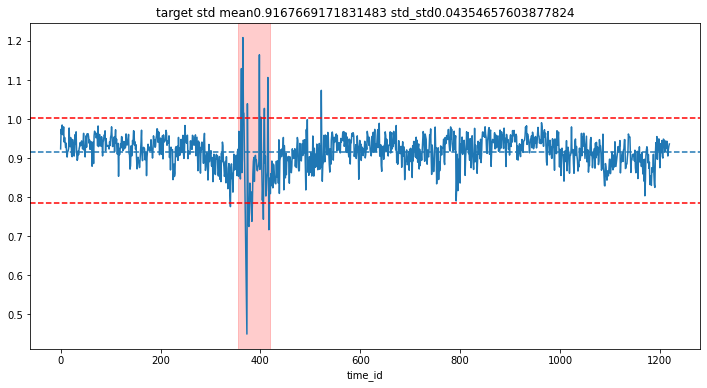

In [ ]:
plt.figure(figsize=(12,6))
train.groupby('time_id')['target'].std().plot()
std_mean = train.groupby('time_id')['target'].std().mean()
std_std = train.groupby('time_id')['target'].std().std()
plt.axhline(std_mean, linestyle='--')
plt.axhline(std_mean+2.*std_std, linestyle='--', color='r')
plt.axhline(std_mean-3.*std_std, linestyle='--', color='r')
plt.axvspan(355, 420, color='red', alpha=0.2)
plt.title(f'target std mean{std_mean} std_std{std_std}')
plt.savefig('target_std_vspan.png')

In [ ]:
std_mean-3.*std_std, std_mean+2.*std_std

(0.7861271890668136, 1.0038600692607047)

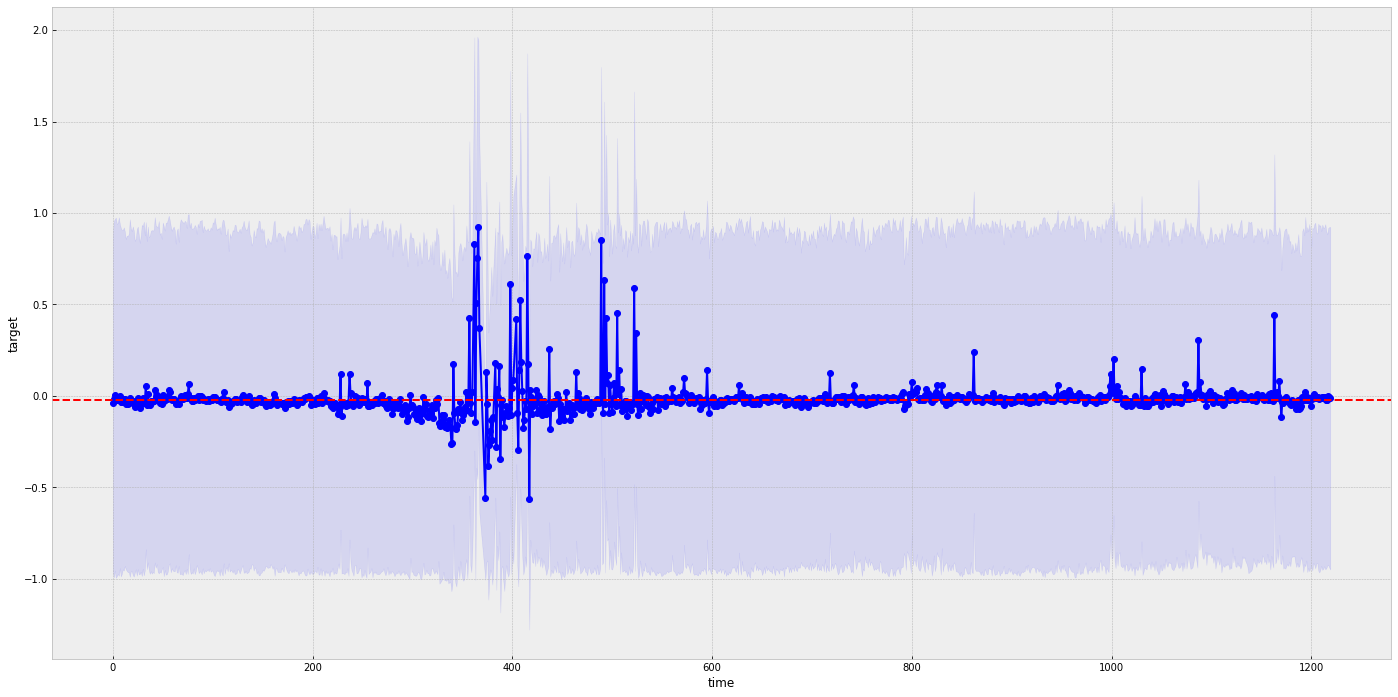

In [ ]:
time2target_mean = train.groupby(['time_id'])['target'].mean()
time2target_std = train.groupby(['time_id'])['target'].std()

_, axes = plt.subplots(1, 1, figsize=(24, 12))
plt.fill_between(
        time2target_mean.index,
        time2target_mean - time2target_std,
        time2target_mean + time2target_std,
        alpha=0.1,
        color="b",
    )
plt.plot(
        time2target_mean.index, time2target_mean, "o-", color="b", label="Training score"
    )
plt.axhline(y=mean_mean_target, color='r', linestyle='--', label="mean")
axes.set_ylabel("target")
axes.set_xlabel("time")
plt.savefig('target_mean_and_std.jpg')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

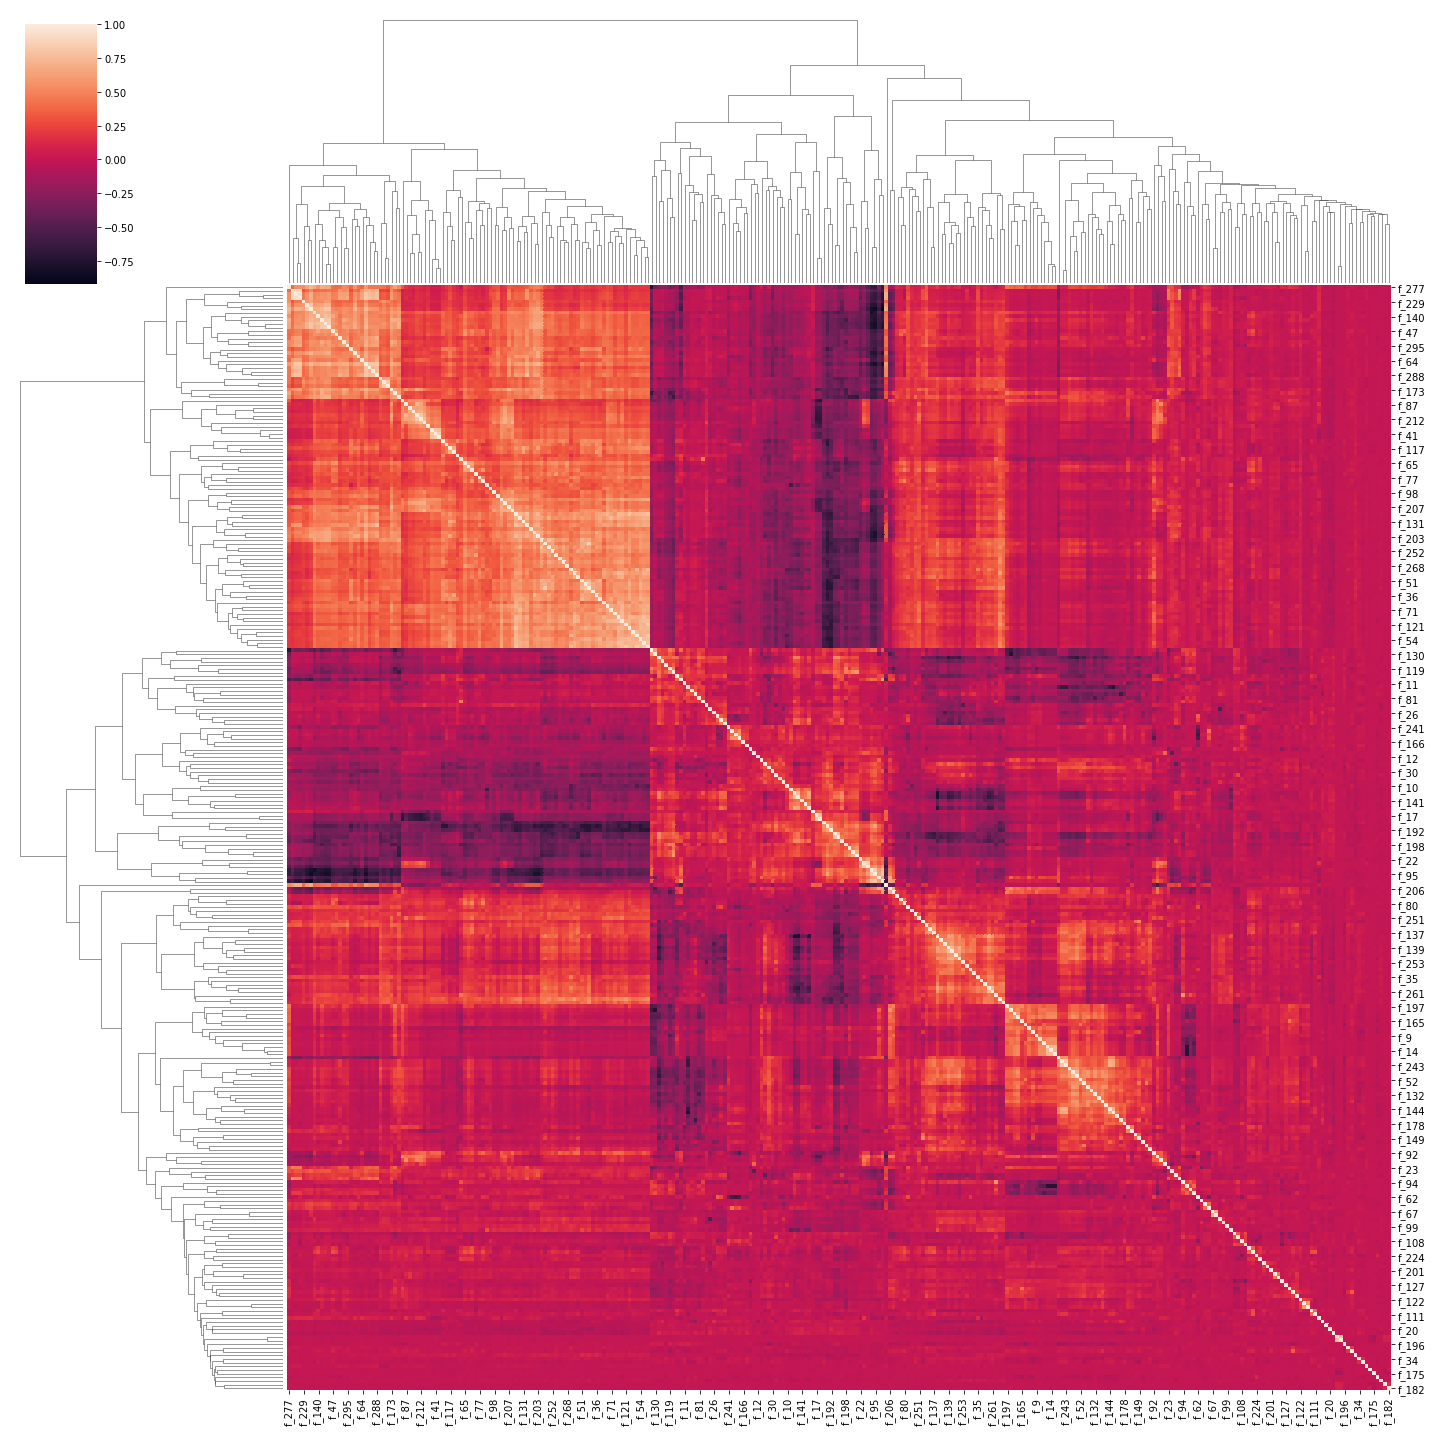

In [ ]:
# Mini Correlation Plot
plt.figure()
features = [f'f_{i}' for i in range(300)]

sample_corr=train.sample(frac=0.01, random_state=18)
corr = sample_corr[['target']+features].corr()
sns.clustermap(corr, figsize=(20, 20))#, cmap="mako_r")
plt.savefig('mini_features_correlation_clustermap.jpg')

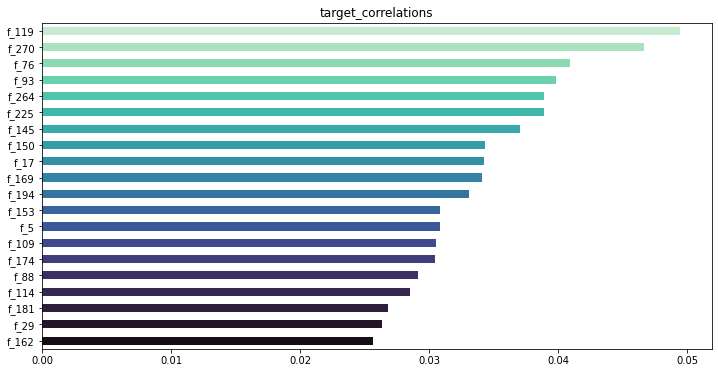

In [ ]:
tar_corr = []
features = [f'f_{i}' for i in range(300)]
for f in features:
    corr = np.corrcoef(train['target'].values, train[f].values)[0][1]
    tar_corr.append(corr)

feat_importances = pd.Series(tar_corr, index=features)
feat_importances.nlargest(20).plot(kind='barh', figsize=(12, 6),
                                   color=("#c6ebd1","#abe2be","#8bdab2","#68d1ad","#4fc5ad",
                                          "#40b7ad","#38aaac","#359caa","#348fa7","#3482a4",
                                           "#3573a1","#37659e","#3b5799","#40498e","#413d7b",
                                         "#3d3164","#37284f","#2e1e3b","#241628","#180d16")).invert_yaxis()
plt.title("target_correlations")
plt.savefig("target_correlations.png")
plt.show()

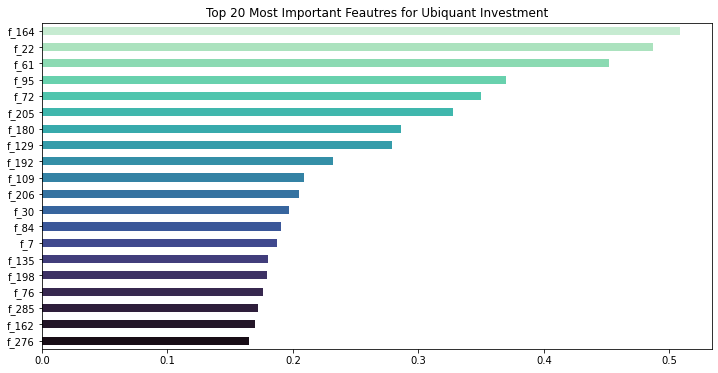

In [ ]:
features = [f'f_{i}' for i in range(300)]

obs_by_asset = train.groupby(['investment_id'])['target'].count().to_dict()
target = train.investment_id.copy().replace(obs_by_asset).astype(np.int16)
del(obs_by_asset)

corrs = []
for col in features:
    corr = np.corrcoef(target.values, train[col].values)[0][1]
    corrs.append(corr)    
del(target)

feat_importances = pd.Series(corrs, index=features)
feat_importances.nlargest(20).plot(kind='barh', figsize=(12, 6),
                                   color=("#c6ebd1","#abe2be","#8bdab2","#68d1ad","#4fc5ad",
                                          "#40b7ad","#38aaac","#359caa","#348fa7","#3482a4",
                                           "#3573a1","#37659e","#3b5799","#40498e","#413d7b",
                                         "#3d3164","#37284f","#2e1e3b","#241628","#180d16")).invert_yaxis()
plt.title("Top 20 Most Important Feautres for Ubiquant Investment")
plt.savefig('investment_id_count_correlation.png')
plt.show()

In [ ]:
# Decomposition
from sklearn.decomposition import TruncatedSVD # 基本的にPCAと同じ
svd = TruncatedSVD(n_components=50)
# vecs_list = svd.fit_transform(df)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=2) # perplexityで結果が大きく変化。
# vecs_list = tsne.fit_transform(df)
import umap
model_umap = umap.UMAP(n_components=2,n_neighbors=3) 
# vecs_list = model_umap.fit_transform(df)

AttributeError: ignored

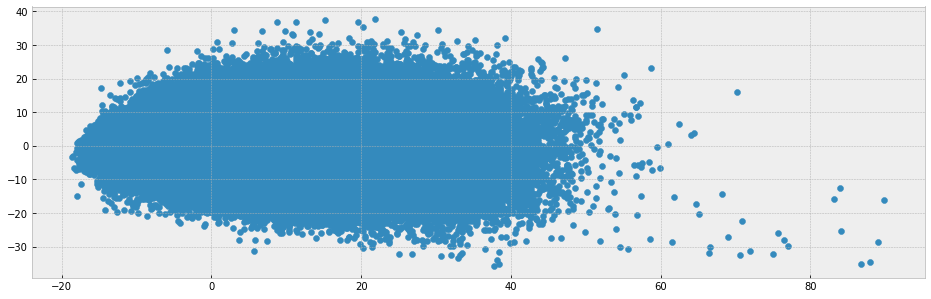

In [ ]:
svd_list = svd.fit_transform(train.iloc[:, 4:])
plt.scatter(svd_list.T[0], svd_list.T[1])
svd.explained_variance_ratio_

In [ ]:
from collections import defaultdict
# lightGBM
seed = 0
params = {
    'learning_rate':0.05,
    "objective": "regression",
    "metric": "rmse",
    'boosting_type': "gbdt",
    'verbosity': -1,
    'n_jobs': -1, 
    'seed': 0,
    'lambda_l1': 0.03627602394442367, 
    'lambda_l2': 0.43523855951142926, 
    'num_leaves': 114, 
    'feature_fraction': 0.9505625064462319, 
    'bagging_fraction': 0.9785558707339647, 
    'bagging_freq': 7, 
    'max_depth': -1, 
    'max_bin': 501, 
    'min_data_in_leaf': 374,
    'n_estimators': 1000, 
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# TODO: replace with feval_pearsonr
def feval_rmse(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'rmse', rmse(y_true, y_pred), False

# https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302480
def feval_pearsonr(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'pearsonr', pearsonr(y_true, y_pred)[0], True


    def run_single_fold(fold, trn_ind, val_ind):
        train_dataset = lgb.Dataset(train.loc[trn_ind, features], y.loc[trn_ind], categorical_feature=cat_features)
        valid_dataset = lgb.Dataset(train.loc[val_ind, features], y.loc[val_ind], categorical_feature=cat_features)
        model = lgb.train(
            params,
            train_set = train_dataset, 
            valid_sets = [train_dataset, valid_dataset], 
            verbose_eval=100,
            early_stopping_rounds=50,
            feval = feval_pearsonr
        )
        joblib.dump(model, f'lgbm_seed{args.seed}_{fold}_{info}.pkl')
        preds = model.predict(train.loc[val_ind, features])
        train.loc[val_ind, "preds"] = preds

        del train_dataset, valid_dataset, model
        gc.collect()

def lightgbm_fit(df):
    seed = 0
    folds = 10
    #####
    feature_importance = []
    models = []
    preds = []
    vals = []
    scores = defaultdict(list)

    features = [f'f_{i}' for i in range(300)]

    skf = StratifiedKFold(folds, shuffle = True, random_state = params['seed'])
    def fit_one_fold(fold, tra_idx, val_idx):
        train_dataset = lgb.Dataset(df.loc[tra_idx, features], df.loc[tra_idx, 'target'])# , categorical_feature=cat_features)
        valid_dataset = lgb.Dataset(df.loc[val_idx, features], df.loc[val_idx, 'target'])# , categorical_feature=cat_features)

        model = lgb.train(
            params,
            train_set = train_dataset, 
            valid_sets = [train_dataset, valid_dataset], 
            verbose_eval=100,
            early_stopping_rounds=50,
            feval = feval_pearsonr
        )
        models.append(model)
        joblib.dump(model, f'lgbm_seed{seed}_{fold}.pkl')

        preds = model.predict(train.loc[val_idx, features])
        df.loc[val_idx, "preds"] = preds

        scores["rmse"].append(rmse(train.loc[val_idx,'target'], preds))
        scores["pearsonr"].append(pearsonr(train.loc[val_idx,'target'], preds)[0])

        fold_importance_df= pd.DataFrame({'feature': features, 'importance': model.feature_importance(), 'fold': fold})
        feature_importance.append(fold_importance_df)

        plt.figure(figsize=(8,6))
        plt.scatter(preds, train.loc[val_idx,'target'])
        plt.savefig(f'lgb_fold{fold}_pred_target_scatter.png')

        plt.figure(figsize=(8,6))
        sns.histplot(preds, alpha=0.4, color='red')
        sns.histplot(train.loc[val_idx,'target'], alpha=0.4)
        plt.savefig(f'lgb_fold{fold}_pred_target_histgram.png')


        with open('scores.pkl', mode='wb') as f:
            pickle.dump(scores, f)
        with open('feature_importance.pkl', mode='wb') as f:
            pickle.dump(feature_importance, f)

    for fold, (tra_idx, val_idx) in enumerate(skf.split(df, df['investment_id'])):
        fit_one_fold(fold, tra_idx, val_idx)
    return df, models, scores, feature_importance

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.901055	training's pearsonr: 0.223475	valid_1's rmse: 0.906167	valid_1's pearsonr: 0.182028
[200]	training's rmse: 0.891368	training's pearsonr: 0.276189	valid_1's rmse: 0.9008	valid_1's pearsonr: 0.212714
[300]	training's rmse: 0.883408	training's pearsonr: 0.313019	valid_1's rmse: 0.897143	valid_1's pearsonr: 0.230621
[400]	training's rmse: 0.876782	training's pearsonr: 0.341332	valid_1's rmse: 0.894765	valid_1's pearsonr: 0.24126
[500]	training's rmse: 0.871058	training's pearsonr: 0.36439	valid_1's rmse: 0.893117	valid_1's pearsonr: 0.248105
[600]	training's rmse: 0.866096	training's pearsonr: 0.383771	valid_1's rmse: 0.892063	valid_1's pearsonr: 0.252142
[700]	training's rmse: 0.861398	training's pearsonr: 0.401319	valid_1's rmse: 0.891084	valid_1's pearsonr: 0.255966
[800]	training's rmse: 0.856974	training's pearsonr: 0.416934	valid_1's rmse: 0.890206	valid_1's pearsonr: 0.259253
[900]	training

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.900725	training's pearsonr: 0.222344	valid_1's rmse: 0.910457	valid_1's pearsonr: 0.178289
[200]	training's rmse: 0.890839	training's pearsonr: 0.276514	valid_1's rmse: 0.905015	valid_1's pearsonr: 0.210028
[300]	training's rmse: 0.882898	training's pearsonr: 0.313322	valid_1's rmse: 0.901483	valid_1's pearsonr: 0.227559
[400]	training's rmse: 0.876381	training's pearsonr: 0.341457	valid_1's rmse: 0.899401	valid_1's pearsonr: 0.236789
[500]	training's rmse: 0.870688	training's pearsonr: 0.364338	valid_1's rmse: 0.897788	valid_1's pearsonr: 0.243598
[600]	training's rmse: 0.865644	training's pearsonr: 0.383982	valid_1's rmse: 0.896614	valid_1's pearsonr: 0.248387
[700]	training's rmse: 0.860887	training's pearsonr: 0.401601	valid_1's rmse: 0.895579	valid_1's pearsonr: 0.25254
[800]	training's rmse: 0.856365	training's pearsonr: 0.417454	valid_1's rmse: 0.894637	valid_1's pearsonr: 0.25623
[900]	traini

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.900907	training's pearsonr: 0.223046	valid_1's rmse: 0.907953	valid_1's pearsonr: 0.18301
[200]	training's rmse: 0.891139	training's pearsonr: 0.276324	valid_1's rmse: 0.902587	valid_1's pearsonr: 0.213506
[300]	training's rmse: 0.883167	training's pearsonr: 0.313277	valid_1's rmse: 0.899101	valid_1's pearsonr: 0.230288
[400]	training's rmse: 0.876483	training's pearsonr: 0.341745	valid_1's rmse: 0.896679	valid_1's pearsonr: 0.2412
[500]	training's rmse: 0.870798	training's pearsonr: 0.364642	valid_1's rmse: 0.895174	valid_1's pearsonr: 0.247268
[600]	training's rmse: 0.865653	training's pearsonr: 0.384519	valid_1's rmse: 0.893921	valid_1's pearsonr: 0.252325
[700]	training's rmse: 0.86106	training's pearsonr: 0.401514	valid_1's rmse: 0.892978	valid_1's pearsonr: 0.255924
[800]	training's rmse: 0.856624	training's pearsonr: 0.417231	valid_1's rmse: 0.892177	valid_1's pearsonr: 0.258888
[900]	training

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.901174	training's pearsonr: 0.223057	valid_1's rmse: 0.905464	valid_1's pearsonr: 0.182479
[200]	training's rmse: 0.891345	training's pearsonr: 0.276811	valid_1's rmse: 0.900047	valid_1's pearsonr: 0.213409
[300]	training's rmse: 0.883426	training's pearsonr: 0.313407	valid_1's rmse: 0.896549	valid_1's pearsonr: 0.230247
[400]	training's rmse: 0.876717	training's pearsonr: 0.342157	valid_1's rmse: 0.894149	valid_1's pearsonr: 0.240928
[500]	training's rmse: 0.871073	training's pearsonr: 0.36494	valid_1's rmse: 0.892594	valid_1's pearsonr: 0.247316
[600]	training's rmse: 0.865978	training's pearsonr: 0.384264	valid_1's rmse: 0.891286	valid_1's pearsonr: 0.252533
[700]	training's rmse: 0.861238	training's pearsonr: 0.402043	valid_1's rmse: 0.890326	valid_1's pearsonr: 0.256269
[800]	training's rmse: 0.856756	training's pearsonr: 0.417696	valid_1's rmse: 0.889487	valid_1's pearsonr: 0.259351
[900]	train

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.901282	training's pearsonr: 0.22225	valid_1's rmse: 0.905505	valid_1's pearsonr: 0.18925
[200]	training's rmse: 0.891542	training's pearsonr: 0.275646	valid_1's rmse: 0.900024	valid_1's pearsonr: 0.219203
[300]	training's rmse: 0.883541	training's pearsonr: 0.312859	valid_1's rmse: 0.896231	valid_1's pearsonr: 0.237206
[400]	training's rmse: 0.876918	training's pearsonr: 0.341368	valid_1's rmse: 0.89397	valid_1's pearsonr: 0.24674
[500]	training's rmse: 0.871393	training's pearsonr: 0.363634	valid_1's rmse: 0.892381	valid_1's pearsonr: 0.252988
[600]	training's rmse: 0.866323	training's pearsonr: 0.38327	valid_1's rmse: 0.891157	valid_1's pearsonr: 0.257665
[700]	training's rmse: 0.861523	training's pearsonr: 0.400948	valid_1's rmse: 0.890105	valid_1's pearsonr: 0.26155
[800]	training's rmse: 0.8571	training's pearsonr: 0.416759	valid_1's rmse: 0.889286	valid_1's pearsonr: 0.264544
[900]	training's r

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.901193	training's pearsonr: 0.223292	valid_1's rmse: 0.904963	valid_1's pearsonr: 0.186869
[200]	training's rmse: 0.891395	training's pearsonr: 0.276699	valid_1's rmse: 0.899339	valid_1's pearsonr: 0.218384
[300]	training's rmse: 0.88348	training's pearsonr: 0.313523	valid_1's rmse: 0.895757	valid_1's pearsonr: 0.235414
[400]	training's rmse: 0.876903	training's pearsonr: 0.341952	valid_1's rmse: 0.893657	valid_1's pearsonr: 0.244262
[500]	training's rmse: 0.871169	training's pearsonr: 0.364698	valid_1's rmse: 0.891843	valid_1's pearsonr: 0.251735
[600]	training's rmse: 0.86611	training's pearsonr: 0.384312	valid_1's rmse: 0.890704	valid_1's pearsonr: 0.256023
[700]	training's rmse: 0.861478	training's pearsonr: 0.401402	valid_1's rmse: 0.889683	valid_1's pearsonr: 0.259902
[800]	training's rmse: 0.857041	training's pearsonr: 0.417333	valid_1's rmse: 0.888737	valid_1's pearsonr: 0.263597
[900]	traini

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.901154	training's pearsonr: 0.223541	valid_1's rmse: 0.905147	valid_1's pearsonr: 0.182822
[200]	training's rmse: 0.891477	training's pearsonr: 0.276102	valid_1's rmse: 0.899774	valid_1's pearsonr: 0.213286
[300]	training's rmse: 0.883548	training's pearsonr: 0.313058	valid_1's rmse: 0.896214	valid_1's pearsonr: 0.230697
[400]	training's rmse: 0.876908	training's pearsonr: 0.341323	valid_1's rmse: 0.893934	valid_1's pearsonr: 0.24061
[500]	training's rmse: 0.871284	training's pearsonr: 0.364348	valid_1's rmse: 0.892396	valid_1's pearsonr: 0.247039
[600]	training's rmse: 0.866087	training's pearsonr: 0.384123	valid_1's rmse: 0.891007	valid_1's pearsonr: 0.252681
[700]	training's rmse: 0.861433	training's pearsonr: 0.401166	valid_1's rmse: 0.890024	valid_1's pearsonr: 0.256418
[800]	training's rmse: 0.856842	training's pearsonr: 0.417482	valid_1's rmse: 0.889073	valid_1's pearsonr: 0.260118
[900]	train

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.901032	training's pearsonr: 0.223407	valid_1's rmse: 0.906597	valid_1's pearsonr: 0.18272
[200]	training's rmse: 0.89135	training's pearsonr: 0.276412	valid_1's rmse: 0.9013	valid_1's pearsonr: 0.212905
[300]	training's rmse: 0.883319	training's pearsonr: 0.313285	valid_1's rmse: 0.897535	valid_1's pearsonr: 0.231294
[400]	training's rmse: 0.876608	training's pearsonr: 0.341762	valid_1's rmse: 0.895039	valid_1's pearsonr: 0.242478
[500]	training's rmse: 0.870878	training's pearsonr: 0.3648	valid_1's rmse: 0.893423	valid_1's pearsonr: 0.249108
[600]	training's rmse: 0.865761	training's pearsonr: 0.384327	valid_1's rmse: 0.892145	valid_1's pearsonr: 0.254195
[700]	training's rmse: 0.861119	training's pearsonr: 0.401586	valid_1's rmse: 0.891223	valid_1's pearsonr: 0.257666
[800]	training's rmse: 0.856632	training's pearsonr: 0.417847	valid_1's rmse: 0.890532	valid_1's pearsonr: 0.260149
[900]	training's

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.901273	training's pearsonr: 0.22259	valid_1's rmse: 0.905386	valid_1's pearsonr: 0.18207
[200]	training's rmse: 0.891594	training's pearsonr: 0.275748	valid_1's rmse: 0.900003	valid_1's pearsonr: 0.213003
[300]	training's rmse: 0.883639	training's pearsonr: 0.312529	valid_1's rmse: 0.896308	valid_1's pearsonr: 0.231012
[400]	training's rmse: 0.876909	training's pearsonr: 0.341141	valid_1's rmse: 0.893778	valid_1's pearsonr: 0.242359
[500]	training's rmse: 0.871278	training's pearsonr: 0.364119	valid_1's rmse: 0.892082	valid_1's pearsonr: 0.249575
[600]	training's rmse: 0.866143	training's pearsonr: 0.383711	valid_1's rmse: 0.890638	valid_1's pearsonr: 0.255447
[700]	training's rmse: 0.86147	training's pearsonr: 0.401065	valid_1's rmse: 0.889721	valid_1's pearsonr: 0.258847
[800]	training's rmse: 0.856998	training's pearsonr: 0.41701	valid_1's rmse: 0.888915	valid_1's pearsonr: 0.261818
[900]	training

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.901691	training's pearsonr: 0.223635	valid_1's rmse: 0.900263	valid_1's pearsonr: 0.18572
[200]	training's rmse: 0.891859	training's pearsonr: 0.277217	valid_1's rmse: 0.894913	valid_1's pearsonr: 0.215748
[300]	training's rmse: 0.883895	training's pearsonr: 0.313789	valid_1's rmse: 0.891371	valid_1's pearsonr: 0.232678
[400]	training's rmse: 0.87732	training's pearsonr: 0.341748	valid_1's rmse: 0.889151	valid_1's pearsonr: 0.242276
[500]	training's rmse: 0.871756	training's pearsonr: 0.364223	valid_1's rmse: 0.887668	valid_1's pearsonr: 0.248275
[600]	training's rmse: 0.866619	training's pearsonr: 0.383982	valid_1's rmse: 0.886441	valid_1's pearsonr: 0.25318
[700]	training's rmse: 0.861923	training's pearsonr: 0.401478	valid_1's rmse: 0.885402	valid_1's pearsonr: 0.257338
[800]	training's rmse: 0.85749	training's pearsonr: 0.417224	valid_1's rmse: 0.884627	valid_1's pearsonr: 0.260172
[900]	training

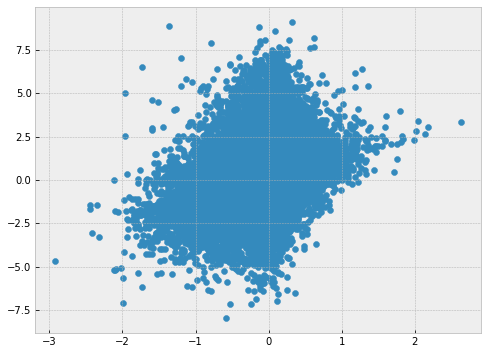

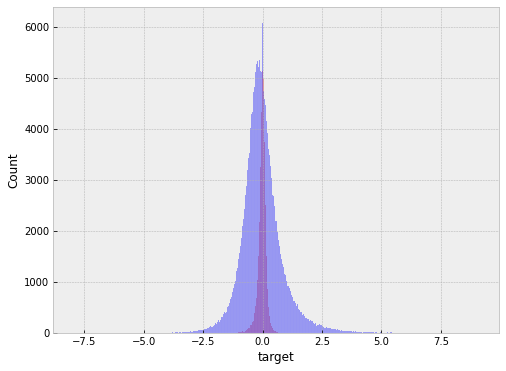

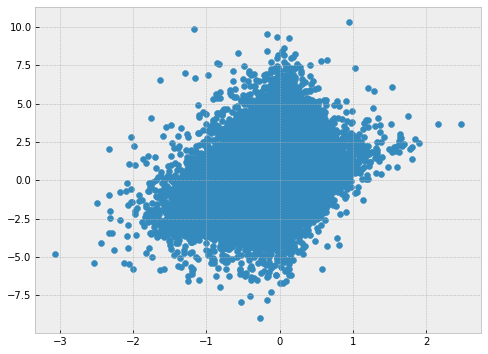

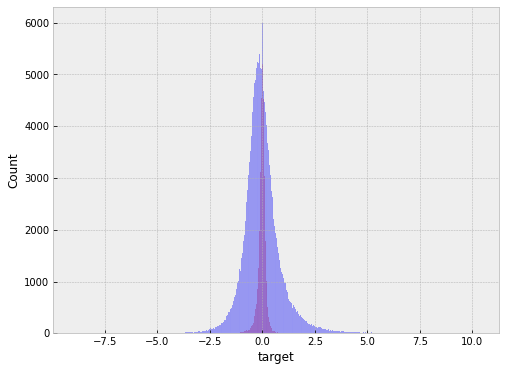

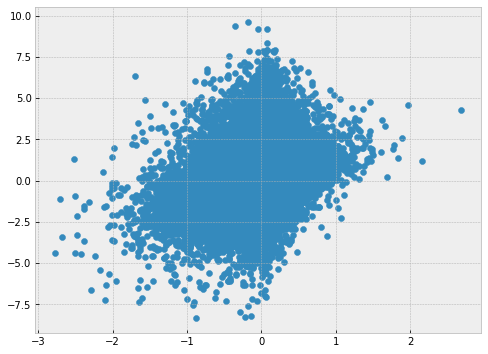

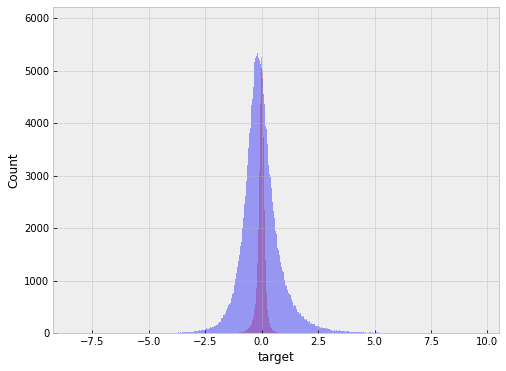

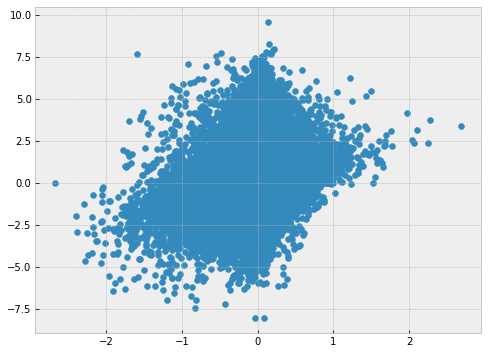

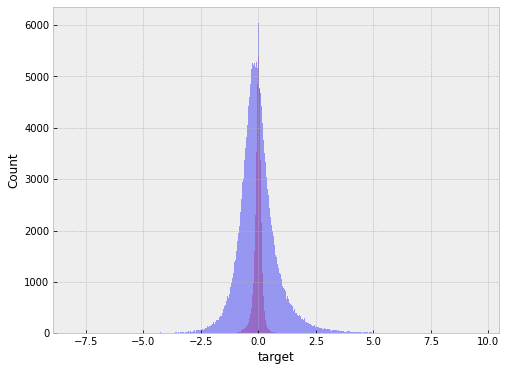

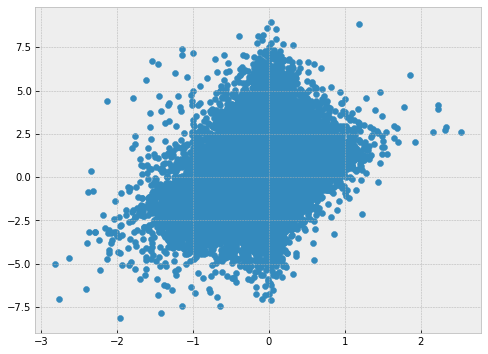

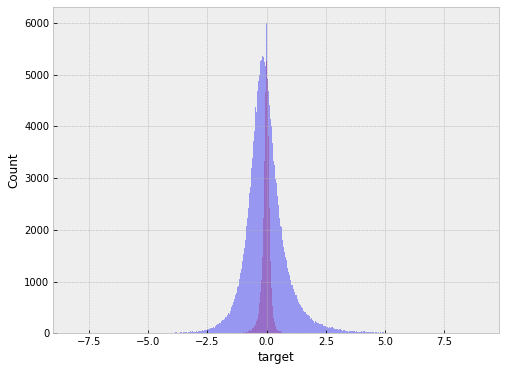

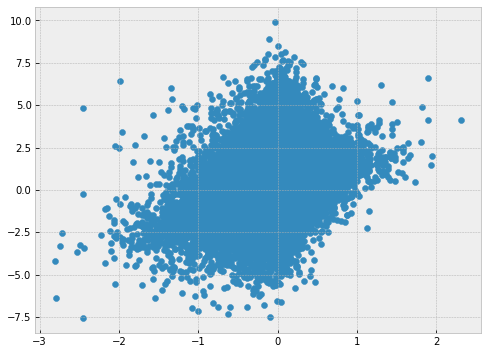

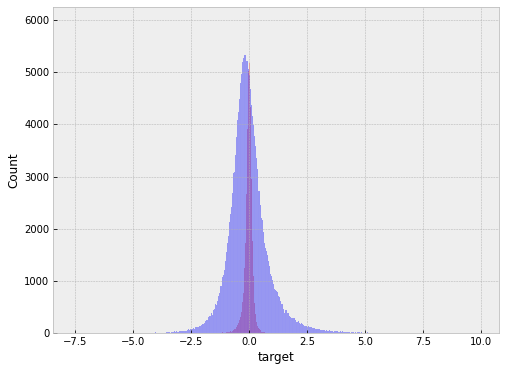

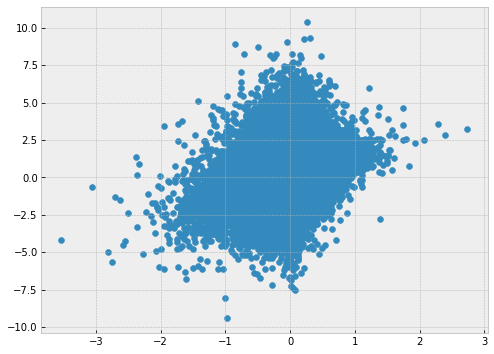

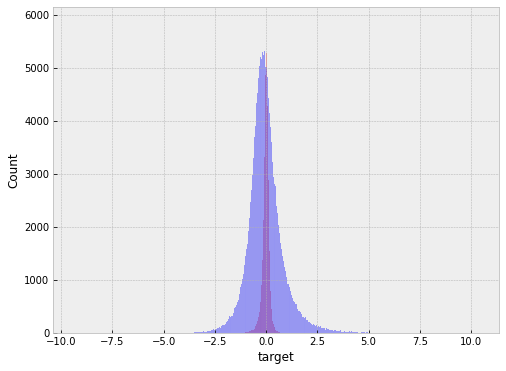

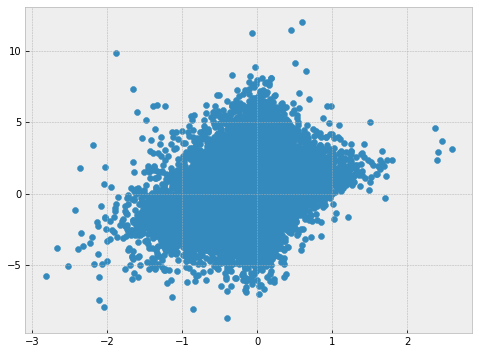

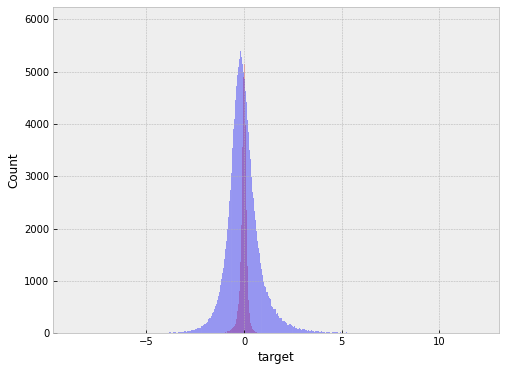

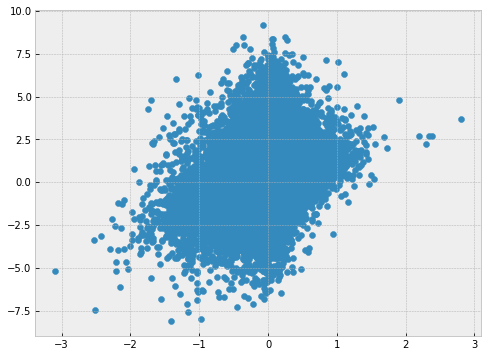

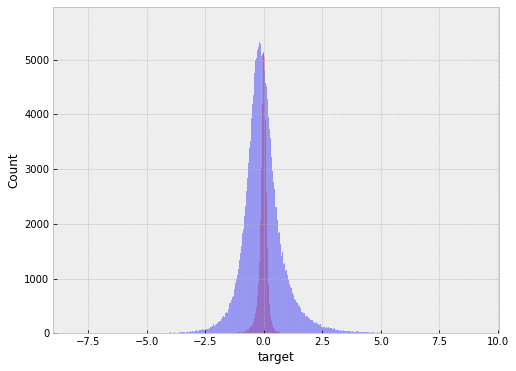

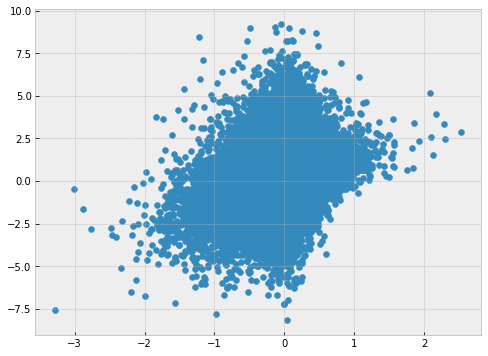

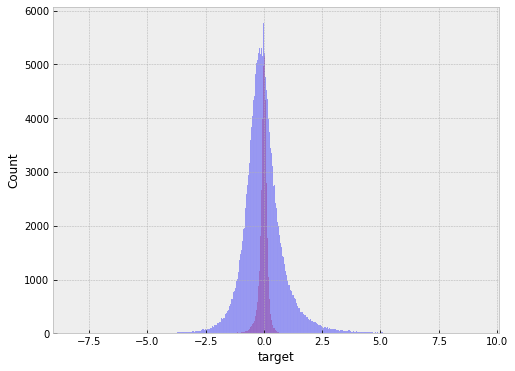

In [ ]:
train, models, scores, features_importance = lightgbm_fit(train)

In [ ]:
%ls -a

checkpoint                               protos/
EDA/                                     QuantileScaler.pkl
example_sample_submission.parquet        QuantileTransformer.pkl
example_test.parquet                     res/
.git/                                    RobustScaler.pkl
holidays_of_china_from_2014_to_2030.csv  StandardScaler.pkl
ideas.txt                                tf_datas/
investment_ids/                          tf_models/
investment_ids.csv                       train_low_mem.parquet
model.png                                train.parquet


In [ ]:
np.mean(scores['pearsonr'])

0.2652124659696894

['f_231',
 'f_165',
 'f_63',
 'f_170',
 'f_108',
 'f_62',
 'f_263',
 'f_225',
 'f_145',
 'f_175',
 'f_153',
 'f_142',
 'f_182',
 'f_74',
 'f_241',
 'f_272',
 'f_8',
 'f_200',
 'f_22',
 'f_99',
 'f_183',
 'f_73']

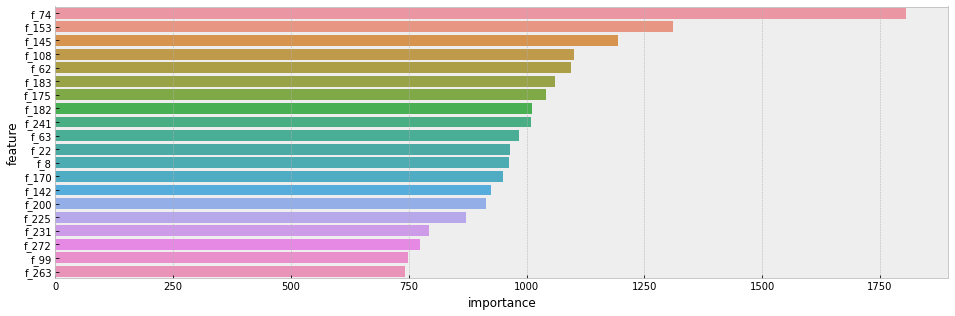

In [ ]:
with open('/content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction/EDA/feature_importance.pkl', mode='rb') as f:
    feature_importance = pickle.load(f)
with open('/content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction/EDA/scores.pkl', mode='rb') as f:
    scores = pickle.load(f)

features = []
for i in range(10):
    features.extend(feature_importance[i].nlargest(20, 'importance')['feature'].values.tolist())

sns.barplot(data=feature_importance[i].nlargest(20, 'importance').sort_values(by='importance',ascending=False), x='importance', y='feature')
features = list(set(features))
features

In [ ]:
def visualize_feature(df, i):
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12*3, 11*5), dpi=100)
    for j in range(15):
        y = j//3
        x = j%3
        axes[y][x].scatter(df[f'f_{i+j}'], df['target'])
        axes[y][x].axvline(df[f'f_{i+j}'].mean(), label='Mean', color='r', linewidth=2, linestyle='--')
        axes[y][x].legend(prop={'size': 15})
        axes[y][x].set_ylabel('target')
        axes[y][x].set_xlabel(f'f_{i+j}')
    plt.savefig(f'target_feature_f_{i}-{i+15}')
    plt.close(fig)

now = 0
for i in tqdm(range(20)):
    visualize_feature(train, now)
    now += 15


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

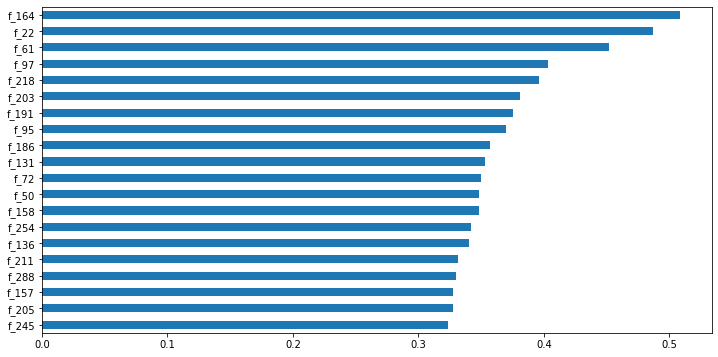

In [ ]:
obs_by_asset = train.groupby(['investment_id'])['target'].count().to_dict()
target = train.investment_id.copy().replace(obs_by_asset).astype(np.int16)
features = train.columns[4:]

corrs = list()
for col in tqdm(features):
    corr = np.corrcoef(target, train[col])[0][1]
    corrs.append(corr)
    
feat_importances = pd.Series(np.abs(corrs), index=features)
feat_importances.nlargest(20).plot(kind='barh', figsize=(12, 6)).invert_yaxis()
plt.show()

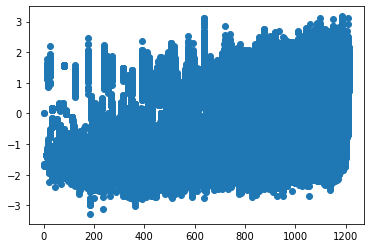

In [ ]:
# fig, ax = plt.subplots(1,1)
plt.scatter(target, train['f_164'])

In [ ]:
np.corrcoef(target, train[col])

array([[ 1.        , -0.28913559],
       [-0.28913559,  1.        ]])

In [ ]:
feat_importances

f_0      0.004736
f_1     -0.018085
f_2      0.065855
f_3     -0.161303
f_4     -0.173766
           ...   
f_295   -0.311550
f_296   -0.015152
f_297    0.005501
f_298    0.004470
f_299   -0.289136
Length: 300, dtype: float64

## CV Strategy

In [ ]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]


# Ubiquent Market
# https://www.kaggle.com/c/ubiquant-market-prediction/discussion/304036
from typing import Tuple
import numpy as np

class GroupHoldoutTimeSeriesSplit:
    """
    Custom class to create a Group Time Series Split. We ensure
    that the time id values that are in the testing data are not a part
    of the training data & the splits are temporal
    """
    def __init__(self, n_folds: int, holdout_size: int, groups: pd.Series) -> None:
        self.n_folds = n_folds
        self.holdout_size = holdout_size
        self.groups = groups

    def split(self, X) -> Tuple[np.array, np.array]:
        # Take the group column and get the unique values
        unique_time_ids = np.unique(self.groups.values)

        # Split the time ids into the length of the holdout size
        # and reverse so we work backwards in time. Also, makes
        # it easier to get the correct time_id values per
        # split
        array_split_time_ids = np.array_split(
            unique_time_ids, len(unique_time_ids) // self.holdout_size
        )[::-1]

        # Get the first n_folds values
        array_split_time_ids = array_split_time_ids[:self.n_folds]

        for time_ids in array_split_time_ids:
            # Get test index - time id values that are in the time_ids
            test_condition = X['time_id'].isin(time_ids)
            test_index = X.loc[test_condition].index

            # Get train index - The train index will be the time
            # id values right up until the minimum value in the test
            # data - we can also add a gap to this step by
            # time id < (min - gap)
            train_condition = X['time_id'] < (np.min(time_ids))
            train_index = X.loc[train_condition].index

            yield train_index, test_index




import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [ ]:
# lightGBM
from collections import defaultdict
seed = 0
lr = 0.02
epochs = 1000
params = {
    'objective': 'regression',
    'verbose': 0,
    'metric': '',
    'reg_alpha': 5,
    'reg_lambda': 5,
    'min_data_in_leaf': 1000,
    'max_depth': -1,
    'num_leaves': 128,
    'colsample_bytree': 0.3,
    'learning_rate': lr
}

params = {
    'learning_rate':lr,
    "objective": "regression",
    "metric": "rmse",
    'boosting_type': "gbdt",
    'verbosity': -1,
    'n_jobs': -1, 
    'seed': 0,
    'lambda_l1': 0.03627602394442367, 
    'lambda_l2': 0.43523855951142926, 
    'num_leaves': 114, 
    'feature_fraction': 0.9505625064462319, 
    'bagging_fraction': 0.9785558707339647, 
    'bagging_freq': 7, 
    'max_depth': -1, 
    'max_bin': 501, 
    'min_data_in_leaf': 374,
    'n_estimators': epochs, 
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# TODO: replace with feval_pearsonr
def feval_rmse(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'rmse', rmse(y_true, y_pred), False

# https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302480
def feval_pearsonr(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'pearsonr', pearsonr(y_true, y_pred)[0], True

def lightgbm_fit(df):
    seed = 0
    folds = 10
    #####
    feature_importance = []
    models = []
    preds = []
    vals = []
    scores = defaultdict(list)
    cv = 'ManualTimeSeries'
    date = pd.to_datetime(time.time()*10**9).strftime('%m%d')
    OUT_DIR = f'/content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction/EDA/{date}_lgb_models' + f'/lightgbm_{cv}'
    os.makedirs(OUT_DIR, exist_ok=True)

    features = ['investment_id'] + [f'f_{i}' for i in range(300)]

    skf = StratifiedKFold(folds, shuffle = True, random_state = params['seed'])
    folds_border = [1219-120*4, 1219-120*3, 1219-120*2, 1219-120*1]
    time_id_orders = train.time_id.values

    def fit_one_fold(fold, tra_idx, val_idx):
        log_df = pd.read_csv('/content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction/res/result.csv')
        log = {'Model':'lightgbm', 'lr':lr, 'epochs':epochs, 'cv':cv, 'fold':fold}
        train_dataset = lgb.Dataset(df.loc[tra_idx, features], df.loc[tra_idx, 'target'])# , categorical_feature=cat_features)
        valid_dataset = lgb.Dataset(df.loc[val_idx, features], df.loc[val_idx, 'target'])# , categorical_feature=cat_features)

        model = lgb.train(
            params,
            train_set = train_dataset, 
            valid_sets = [train_dataset, valid_dataset], 
            verbose_eval=100,
            early_stopping_rounds=int(40*0.1/0.02),
            feval = feval_pearsonr
        )
        models.append(model)
        joblib.dump(model, f'{OUT_DIR}/lgbm_seed{seed}_{fold}.pkl')

        preds = model.predict(train.loc[val_idx, features])
        df.loc[val_idx, "preds"] = preds

        scores["rmse"].append(rmse(train.loc[val_idx,'target'], preds))
        pearsonr_score = pearsonr(train.loc[val_idx,'target'], preds)[0]
        scores["pearsonr"].append(pearsonr_score)
        log['corr'] = pearsonr_score
        log_df = log_df.append(log, ignore_index=True)
        log_df.to_csv('/content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction/res/result.csv', index=False)

        fold_importance_df= pd.DataFrame({'feature': features, 'importance': model.feature_importance(), 'fold': fold})
        feature_importance.append(fold_importance_df)

        plt.figure(figsize=(8,6))
        plt.scatter(preds, train.loc[val_idx,'target'])
        plt.savefig(f'{OUT_DIR}/lgb_fold{fold}_pred_target_scatter.png')

        plt.figure(figsize=(8,6))
        sns.histplot(preds, alpha=0.4, color='red')
        sns.histplot(train.loc[val_idx,'target'], alpha=0.4)
        plt.savefig(f'{OUT_DIR}/lgb_fold{fold}_pred_target_histgram.png')

        with open(f'{OUT_DIR}/scores.pkl', mode='wb') as f:
            pickle.dump(scores, f)
        with open(f'{OUT_DIR}/feature_importance.pkl', mode='wb') as f:
            pickle.dump(feature_importance, f)

    def retraining(fold):
        with open(f'/content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction/EDA/lgb_models/lightgbm_ManualTimeSeries/lgbm_seed0_{fold}.pkl', mode='rb') as f:
            lgb_model = pickle.load(f)
        ds = lgb.Dataset(train.loc[:, features], train.loc[:, 'target'], weight=1/np.power(train.loc[:, 'target'], 2))
        lgb_model.eval_train(params, ds,
                        # num_boost_round=int(1.1*best_iteration),
                        )
        joblib.dump(lgb_model, f'{OUT_DIR}/retraining_lgbm_seed{seed}_{fold}.pkl')

    # for fold, (tra_idx, val_idx) in enumerate(skf.split(df, df['investment_id'])):
    for fold, border in enumerate(folds_border):
        tra_idx = np.where(time_id_orders<border)[0] # return tuple[0]
        val_idx = np.where((border<=time_id_orders) & (time_id_orders<=border+120))[0] # return tuple[0]
        print('train : ',len(tra_idx), 'validation : ', len(val_idx))
        assert len(set(tra_idx)&set(val_idx))==0, f'Duplicated CV Data fold:{f}, {len(set(tra_idx)&set(val_idx))}'

        # fit_one_fold(fold, tra_idx, val_idx)
        retraining(fold)

    return df, models, scores, feature_importance

In [ ]:
train, models, scores, features_importance = lightgbm_fit(train)

train :  1661912 validation :  342303


TypeError: ignored

In [ ]:
gkf = PurgedGroupTimeSeriesSplit(n_splits = 5, group_gap = 0)
# gkf = GroupHoldoutTimeSeriesSplit(config.n_splits, holdout_size=config.hold_out, groups=train['time_id'])
# PurgedGroupTimeSeries
for fold, (tra_idx, val_idx) in enumerate(gkf.split(train['investment_id'].values, train['investment_id'].values, train['time_id'].values)): # PurgedGroupTimeSeries
# GroupHoldoutTimeSeries
# for fold, (tra_idx, val_idx) in enumerate(gkf.split(X=train)): # GroupHoldoutTimeSeries
    print("=" * 60)
    print(f"Fold : {fold}")
    print("=" * 60)
    print("Train Sample size:", len(tra_idx))
    print("Test Sample size:", len(val_idx))
    tra = train.iloc[tra_idx, :]
    val = train.iloc[val_idx, :]
    break

Fold : 4
Train Sample size: 2490893
Test Sample size: 650517


In [ ]:
folds_border = [1219-120*4, 1219-120*3, 1219-120*2, 1219-120*1]
time_id_orders = train.time_id.values
for f, border in enumerate(folds_border):
    tra_idx = np.where(time_id_orders<border)[0] # return tuple[0]
    val_idx = np.where((border<=time_id_orders) & (time_id_orders<=border+120))[0] # return tuple[0]
    print('train : ',len(tra_idx), 'validation : ', len(val_idx))
    assert len(set(tra_idx)&set(val_idx))==0, f'Duplicated CV Data fold:{f}, {len(set(tra_idx)&set(val_idx))}'

train :  1661912 validation :  342303
train :  2001279 validation :  369305
train :  2367436 validation :  376381
train :  2740634 validation :  400776


In [ ]:
'/content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction/tf_datas'

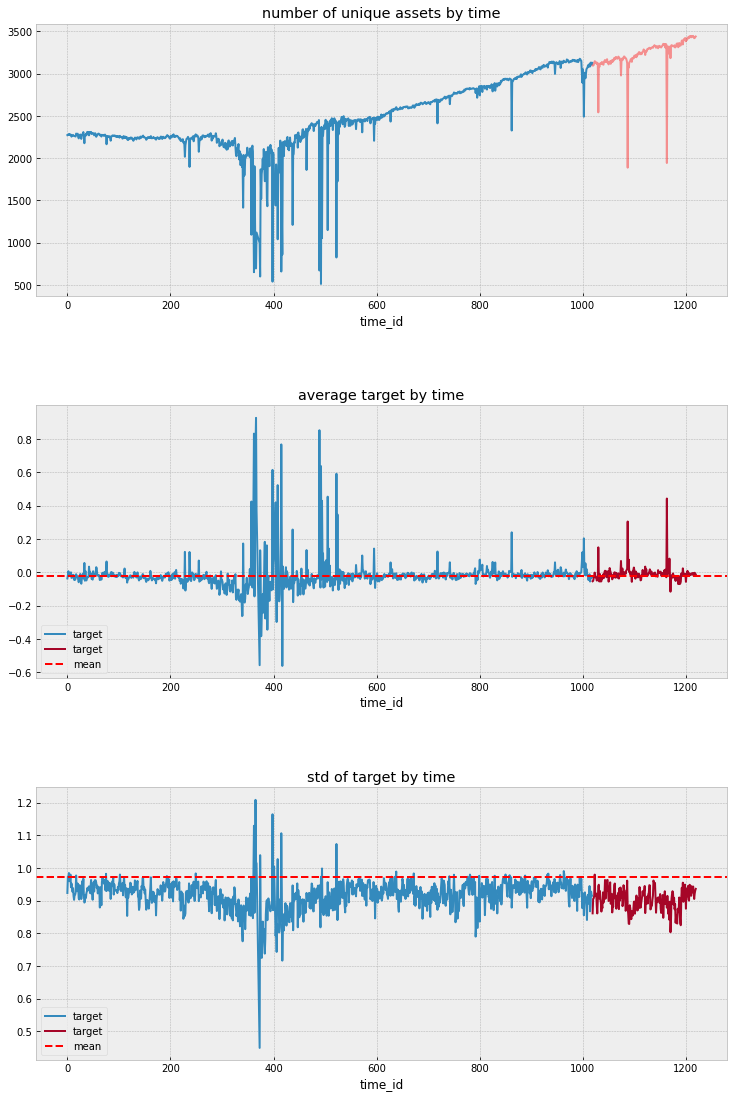

In [ ]:
mean_target = tra.groupby(['investment_id'])['target'].mean()
mean_target_val = val.groupby(['investment_id'])['target'].mean()
mean_mean_target = np.mean(mean_target)
std_target = tra.groupby(['investment_id'])['target'].std()
std_target_val = val.groupby(['investment_id'])['target'].std()
mean_std_target = np.mean(std_target)


plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1,)
tra.groupby('time_id')['investment_id'].nunique().plot()
val.groupby('time_id')['investment_id'].nunique().plot(color='red', alpha=0.4)
# train.groupby('time_id')['investment_id'].nunique().plot(color='green', alpha=0.2)
plt.title("number of unique assets by time")

plt.subplot(3, 1, 2)
tra.groupby('time_id')['target'].mean().plot()
val.groupby('time_id')['target'].mean().plot()
plt.title("average target by time")
plt.axhline(y=mean_mean_target, color='r', linestyle='--', label="mean")
plt.legend(loc='lower left')

plt.subplot(3, 1, 3)
tra.groupby('time_id')['target'].std().plot()
val.groupby('time_id')['target'].std().plot()
plt.title("std of target by time")
plt.axhline(y=mean_std_target, color='r', linestyle='--', label="mean")
plt.legend(loc='lower left')



plt.savefig("number_of_unique_assets_by_time_targetAVG.jpg")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [ ]:
sample_tickers = random.sample(list(train.investment_id.unique()), 10)
plt.figure()
train.query('investment_id in @sample_tickers').set_index(['time_id', 'investment_id'])['target'].unstack()\
     .plot(alpha=0.4, title='Time Series Plot of the Target (sampled tickers)')


In [ ]:
def decode_function(record_bytes):
  return tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {
          "features": tf.io.FixedLenFeature([300], dtype=tf.float32),
          "time_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "investment_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "target": tf.io.FixedLenFeature([], dtype=tf.float32)
      }
  )
def preprocess(item):
    return (item["investment_id"], item["features"]), item["target"]

def make_dataset(file_paths, batch_size=4*1024, mode="train"):
    ds = tf.data.TFRecordDataset(file_paths)
    ds = ds.map(decode_function)
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(batch_size * 4)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

# 一括処理：
def parse_example(example):
    features = tf.io.parse_example(
        example,
        features={
          "features": tf.io.FixedLenFeature([300], dtype=tf.float32),
          "time_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "investment_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "target": tf.io.FixedLenFeature([], dtype=tf.float32)
        }
    )
    return (features['investment_id'], features['features']), (features['target'])

# 既存のdatasetを編集
def ds2scaled_ds(ds, mode='train'):
    def scaled_preprocess(investment_id, feature, target):
        return (investment_id, feature), (target)

    list_investment_id = []
    list_features = []
    list_y = []
    for x, y in tqdm(ds):
        investment_id = x[0].numpy()
        features = x[1].numpy()
        features = scaler.transform(features)
        y = y.numpy()
        list_features.extend(features)
        list_investment_id.extend(investment_id)
        list_y.extend(y)
    
    ds = tf.data.Dataset.from_tensor_slices((list_investment_id, list_features, list_y))
    del list_investment_id, list_features, list_y
    gc.collect()
    ds = ds.map(scaled_preprocess)
    if mode == "train":
        ds = ds.shuffle(config.batch_size * 4)
    ds = ds.batch(config.batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction/tf_datas/'
TRAIN_PATH = '/content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction/tf_datas/PurgedGroupTimeSeriesSplit_MinMaxScaler/PurgedGroupTimeSeriesSplit_MinMaxScaler_fold_0_train.tfrecords'
VALID_PATH = '/content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction/tf_datas/PurgedGroupTimeSeriesSplit_MinMaxScaler/PurgedGroupTimeSeriesSplit_MinMaxScaler_fold_0_test.tfrecords'

In [ ]:
ds_train = tf.data.TFRecordDataset(TRAIN_PATH)
